In [1]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
#from scripts.parse_results import *
import pickle
import matplotlib.patches as mpatches

In [2]:
DB="imdb"
ALG="MSCN"

BASE_DIR="/Users/pari/prism-testbed/all_results/" + DB + "/VLDB/"
#RES_DIR1 = BASE_DIR + "/fixed_baselines/"
RES_DIR1 = BASE_DIR + ALG +  "/default/"
#RES_DIR2 = BASE_DIR + ALG +  "/diff/"

print(RES_DIR1)
assert os.path.exists(RES_DIR1)

SAVE_DIR ="./figures_local/results2/"
make_dir(SAVE_DIR)
FN_TMP = "Fig-" + DB + "-" + ALG + "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}" + ".png"
# FN_TMP.format(ERROR_TYPE = "bar-chart-jerr-rt-NO-Qerr",
#                        SAMPLES_TYPE = "test",
#                        PART = "diff")

COLORS = {}
COLORS["Optimizer Loss"] = "blue"

# COLORS["MSCN - Optimizer Loss"] = "blue"
# COLORS["MSCN - Priority"] = "purple"
# COLORS["MSCN - Q-Error"] = "green"

COLORS[ALG + " - Optimizer Loss"] = "blue"
COLORS[ALG + " - Priority"] = "purple"
COLORS[ALG + " - Q-Error"] = "green"

COLORS["Optimizer Loss Bitmap"] = "lightblue"
COLORS["Q-Error"] = "green"
COLORS["Q-Error Bitmap"] = "lightgreen"
COLORS["Postgres"] = "cyan"
COLORS["True"] = "orange"
print(COLORS)

LINESTYLES = {}
LINESTYLES["Optimizer Loss"] = ":"
# LINESTYLES["MSCN - Optimizer Loss"] = ":"
# LINESTYLES["MSCN - Priority"] = ":"
# LINESTYLES["MSCN - Q-Error"] = "--"

LINESTYLES[ALG + " - Optimizer Loss"] = ":"
LINESTYLES[ALG + " - Priority"] = ":"
LINESTYLES[ALG + " - Q-Error"] = "--"

LINESTYLES["Q-Error Priority"] = ":"

LINESTYLES["Q-Error"] = "--"

LINESTYLES["Optimizer Loss Bitmap"] =  ":"
LINESTYLES["Q-Error Bitmap"] = "--"

LINESTYLES["True"] = "--"
LINESTYLES["Postgres"] = "--"


# LINESTYLES["Optimizer Loss Bitmap"] =  (0, (3, 10, 1, 10))
# LINESTYLES["Q-Error Bitmap"] = (0, (3, 10, 1, 10))

ALG_KEY = {}
ALG_KEY["flow_loss2"] = ALG + " - Optimizer Loss"
ALG_KEY["flow_loss2_bitmap"] = "Optimizer Loss Bitmap"

ALG_KEY["mse"] = ALG + " - Q-Error"
ALG_KEY["saved"] = ALG + " - Q-Error"

ALG_KEY["mse_bitmap"] = "Q-Error Bitmap"
ALG_KEY["mse_priority"] = ALG + " - Priority"


ALG_KEY["postgres"] = "Postgres"
ALG_KEY["true"] = "True"

#TITLE_FMT = "{SAMPLES}-{PARTITION}"
TITLE_KEYS = {}
TITLE_KEYS["job"] = "Join Order Benchmark"
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

/Users/pari/prism-testbed/all_results/imdb/VLDB/MSCN/default/
{'Optimizer Loss': 'blue', 'MSCN - Optimizer Loss': 'blue', 'MSCN - Priority': 'purple', 'MSCN - Q-Error': 'green', 'Optimizer Loss Bitmap': 'lightblue', 'Q-Error': 'green', 'Q-Error Bitmap': 'lightgreen', 'Postgres': 'cyan', 'True': 'orange'}


In [3]:
def arg_filters(df):
    #tmp = df2[df2["template"] == "all_job"]
    #tmp = tmp[tmp["partition"] == 2]
    #tmp = tmp[tmp["alg"] == "flow_loss2"]
    tmp = df[df["flow_features"] == 1]
    tmp = tmp[tmp["hidden_layer_size"] == 512]
    tmp = tmp[tmp["feat_rel_pg_ests_onehot"] == 1]
    return tmp

def get_alg_name(cols, x):
    name = ""
    for col in cols:
        if col == "sample_bitmap":
            if x["sample_bitmap"]:   
                name += "_bitmap"
        elif col == "sampling_priority_alpha":
            if x["sampling_priority_alpha"] > 0:
                name += "_priority"
        else:
            name += x[col]
    return name

In [10]:
RES_DIRS = []
RES_DIRS.append(RES_DIR1)
#RES_DIRS.append(RES_DIR2)

df1s = []
df2s = []
for res_dir in RES_DIRS:
    qerr = get_all_objects(res_dir, "all_qerr.pkl")
    qerr_summary = get_all_objects(res_dir, "qerr.pkl")

    df1s.append(qerr)
    df2s.append(qerr_summary)
    
qerrs = pd.concat(df1s, ignore_index=True)
qerrs.rename(columns={"qerr":"loss"}, inplace=True)
#qerrs = qerrs[~qerrs["loss"].isna()]
qerrs = qerrs[qerrs.samples_type == "test"]
qerrs = qerrs[qerrs.sampling_priority_alpha == 0.0]
qerrs = qerrs[qerrs.alg != "postgres"]
qerrs = qerrs[qerrs.alg != "true"]

qerrs_summary = pd.concat(df2s, ignore_index=True)

In [5]:
qerrs.groupby(["samples_type", "alg", "sampling_priority_alpha"])["loss"].describe()

count        mean  \
samples_type alg        sampling_priority_alpha                          
test         flow_loss2 0.0                      1350153.0  182.018635   
             mse        0.0                      1350153.0    3.005540   

                                                         std           min  \
samples_type alg        sampling_priority_alpha                              
test         flow_loss2 0.0                      4819.316612 -86157.847719   
             mse        0.0                       359.001362 -29711.684463   

                                                      25%       50%       75%  \
samples_type alg        sampling_priority_alpha                                 
test         flow_loss2 0.0                     -1.822904  1.427077  5.952200   
             mse        0.0                     -2.147692 -1.070990  1.864544   

                                                          max  
samples_type alg        sampling_priority_alpha                
test         flow_loss2 0.0                      1.276918e+06  
             mse        0.0                      1.597866e+05

In [6]:
qerrs["qerr"] = qerrs.apply(lambda x: abs(x["loss"]), axis=1)

In [7]:
qerrs.groupby(["samples_type", "alg", "sampling_priority_alpha"])["qerr"].describe()

count        mean  \
samples_type alg        sampling_priority_alpha                          
test         flow_loss2 0.0                      1350153.0  186.211876   
             mse        0.0                      1350153.0   13.344801   

                                                         std       min  \
samples_type alg        sampling_priority_alpha                          
test         flow_loss2 0.0                      4819.156412  1.000000   
             mse        0.0                       358.765839  1.000001   

                                                      25%       50%       75%  \
samples_type alg        sampling_priority_alpha                                 
test         flow_loss2 0.0                      1.624496  2.943390  8.396626   
             mse        0.0                      1.354391  2.001184  3.901414   

                                                          max  
samples_type alg        sampling_priority_alpha                
test         flow_loss2 0.0                      1.276918e+06  
             mse        0.0                      1.597866e+05

In [8]:
qerrs.keys()

Index(['loss', 'samples_type', 'alg', 'sample_bitmap', 'hidden_layer_size',
       'flow_features', 'nn_type', 'max_discrete_featurizing_buckets',
       'sampling_priority_alpha', 'alg_name', 'partition', 'qerr'],
      dtype='object')

In [9]:
qerrs["Overestimate"] = qerrs.apply(lambda x: x["loss"] > 0 ,axis=1)

In [ ]:
qerrs.groupby(["samples_type", "Overestimate", "alg", "sampling_priority_alpha"])["qerr"].describe(
    percentiles=[0.90, 0.99])

In [57]:
est_type = {}
est_type[True] = "Overestimate"
est_type[False] = "Underestimate"
qerrs["Error Kind"] = qerrs.apply(lambda x: est_type[x["Overestimate"]], axis=1)

In [58]:
HUE_ORDER = [ALG + " - Q-Error", ALG + " - Optimizer Loss"]
ORDER = ["Underestimate", "Overestimate"]
qerrs["Estimator"] = qerrs.apply(lambda x: ALG_KEY[x["alg"]] ,axis=1)

In [65]:

def grouped_barplot(df, xfield, yfield, hue_field, hue_labels, estimator, xlabel, ylabel,
                    legend, err_bar_low, err_bar_high, yscale, hue_colors=None, ax=None, ORDER=None):

    plt.style.use('ggplot')
    ekw = {}
    ekw["elinewidth"] = 3.0
    
    if ORDER is None:
        labels = list(set(df[xfield]))
    else:
        labels = ORDER
    print(labels)
    hues = []
    
    hue_vals = defaultdict(list)
    yerrs= defaultdict(list)
    #yerr_highs = defaultdict(list)
    
    for label in labels:
        tmp_df = df[df[xfield] == label]
        for hue_label in hue_labels:
            hdf = tmp_df[tmp_df[hue_field] == hue_label]
            if err_bar_low:
                lowb = np.percentile(hdf[yfield].values, err_bar_low)
                highb = np.percentile(hdf[yfield].values, err_bar_high)
                mid = estimator(hdf[yfield].values)
                lowb = mid - lowb
                highb = highb - mid
                yerrs[hue_label].append([lowb, highb])
                
            hue_vals[hue_label].append(estimator(hdf[yfield].values))
                
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    if ax is None:
        fig, ax = plt.subplots()
    
    #for k, vals in hue_vals.items():
    
    grp1 = hue_vals[hue_labels[0]]
    grp2 = hue_vals[hue_labels[1]]
    yerr1 = np.array(yerrs[hue_labels[0]]).T
    yerr2 = np.array(yerrs[hue_labels[1]]).T

    if hue_colors is not None:
        rects1 = ax.bar(x - width/2, grp1, width, label=hue_labels[0], color=hue_colors[hue_labels[0]], 
                        yerr=yerr1, capsize=8, error_kw=ekw)
        rects2 = ax.bar(x + width/2, grp2, width, label=hue_labels[1], color=hue_colors[hue_labels[1]], 
                        yerr=yerr2, capsize=8, error_kw=ekw)
    else:
        rects1 = ax.bar(x - width/2, grp1, width, label=hue_labels[0])
        rects2 = ax.bar(x + width/2, grp2, width, label=hue_labels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_yscale(yscale)
    
    if legend:
        ax.legend(title=hue_field, loc="center left", bbox_to_anchor=(0.05, 1.10), ncol=2)

['Underestimate', 'Overestimate']
./figures_local/results2/Fig-imdb-MSCNQ-Error-OverEstimateUnderEstimate--test-diff.png


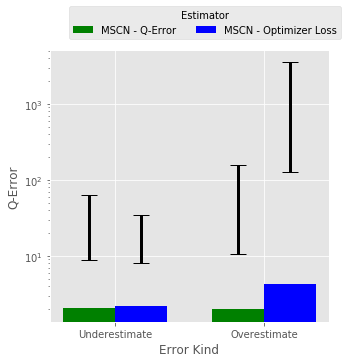

In [67]:
fig, axs = plt.subplots(figsize=(5,5), nrows=1, ncols=1)

legend = True

# grouped_barplot(qerrs, "partition", "loss", "Estimator", ORDER, np.median, 
#                 "Partition", "Q-Error", legend, 90, 99, "log",
#                 hue_colors=COLORS, ax=axs[0])

grouped_barplot(qerrs, "Error Kind", "qerr", "Estimator", HUE_ORDER, np.median, 
                "Error Kind", "Q-Error", legend, 90, 99, "log",
                hue_colors=COLORS, ax=axs, ORDER=ORDER)

# grouped_barplot(rts, "partition", "runtime", "Estimator", ORDER, np.mean, 
#                 "Partition", "Runtime (Seconds)", False, 90, 99, "log",
#                 hue_colors=COLORS, ax=axs[1])

fn = FN_TMP.format(ERROR_TYPE = "Q-Error-OverEstimateUnderEstimate-",
                       SAMPLES_TYPE = "test",
                       PART = "diff")
fn = SAVE_DIR + fn
print(fn)
plt.savefig(fn, bbox_inches="tight")
plt.show()

In [63]:
print(set(qerrs["Error Kind"]))
print(set(qerrs["Estimator"]))

{'Underestimate', 'Overestimate'}
{'MSCN - Optimizer Loss', 'MSCN - Q-Error'}


In [11]:
qerrs_summary.head(20)

,epoch,loss_type,loss,summary_type,template,num_tables,num_samples,samples_type,alg,sample_bitmap,hidden_layer_size,flow_features,nn_type,max_discrete_featurizing_buckets,sampling_priority_alpha,alg_name,partition
0,-1,qerr,7.094342,mean,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
1,-1,qerr,36201.445413,max,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
2,-1,qerr,1.000002,min,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
3,-1,qerr,1.333436,percentile:25,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
4,-1,qerr,1.914675,percentile:50,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
5,-1,qerr,3.517501,percentile:75,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
6,-1,qerr,7.750650,percentile:90,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
7,-1,qerr,64.596670,percentile:99,all,all,1375293,train,mse,0,256,1,mscn_set,10,0.0,mse,0
8,-1,qerr,4.104383,mean,1a,all,128400,train,mse,0,256,1,mscn_set,10,0.0,mse,0
9,-1,qerr,3103.460197,max,1a,all,128400,train,mse,0,256,1,mscn_set,10,0.0,mse,0
